In [50]:
import numpy as np
import os
import pandas as pd
import seaborn as sns

sns.set(palette='flare')

In [51]:
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/2025-08-01_20-14-23"
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/749509"
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/2025-10-31_22-07-14"

dfs = []
for root, dirs, files in os.walk(fs):
    for f in files:
        try:
            if ".csv" in f:
                dfs.append(pd.read_csv(os.path.join(root, f)))
        except Exception as e:
            print(f"Error reading {f}: {e}")

df = pd.concat(dfs, ignore_index=True)

In [52]:
print(df.head())
print(df.info())

  layer  width layer_type fDf data_type     value  iteration  seed  depth  \
0  fc.0   1024      input   f      norm  0.994003          0     0      2   
1  fc.0   1024      input   f      norm  0.994009          1     0      2   
2  fc.0   1024      input   f      norm  0.994035          2     0      2   
3  fc.0   1024      input   f      norm  0.994084          3     0      2   
4  fc.0   1024      input   f      norm  0.994153          4     0      2   

       tag  
0  default  
1  default  
2  default  
3  default  
4  default  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6858 entries, 0 to 6857
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   layer       6858 non-null   object 
 1   width       6858 non-null   int64  
 2   layer_type  6858 non-null   object 
 3   fDf         6858 non-null   object 
 4   data_type   6858 non-null   object 
 5   value       6858 non-null   float64
 6   iteration   6858 no

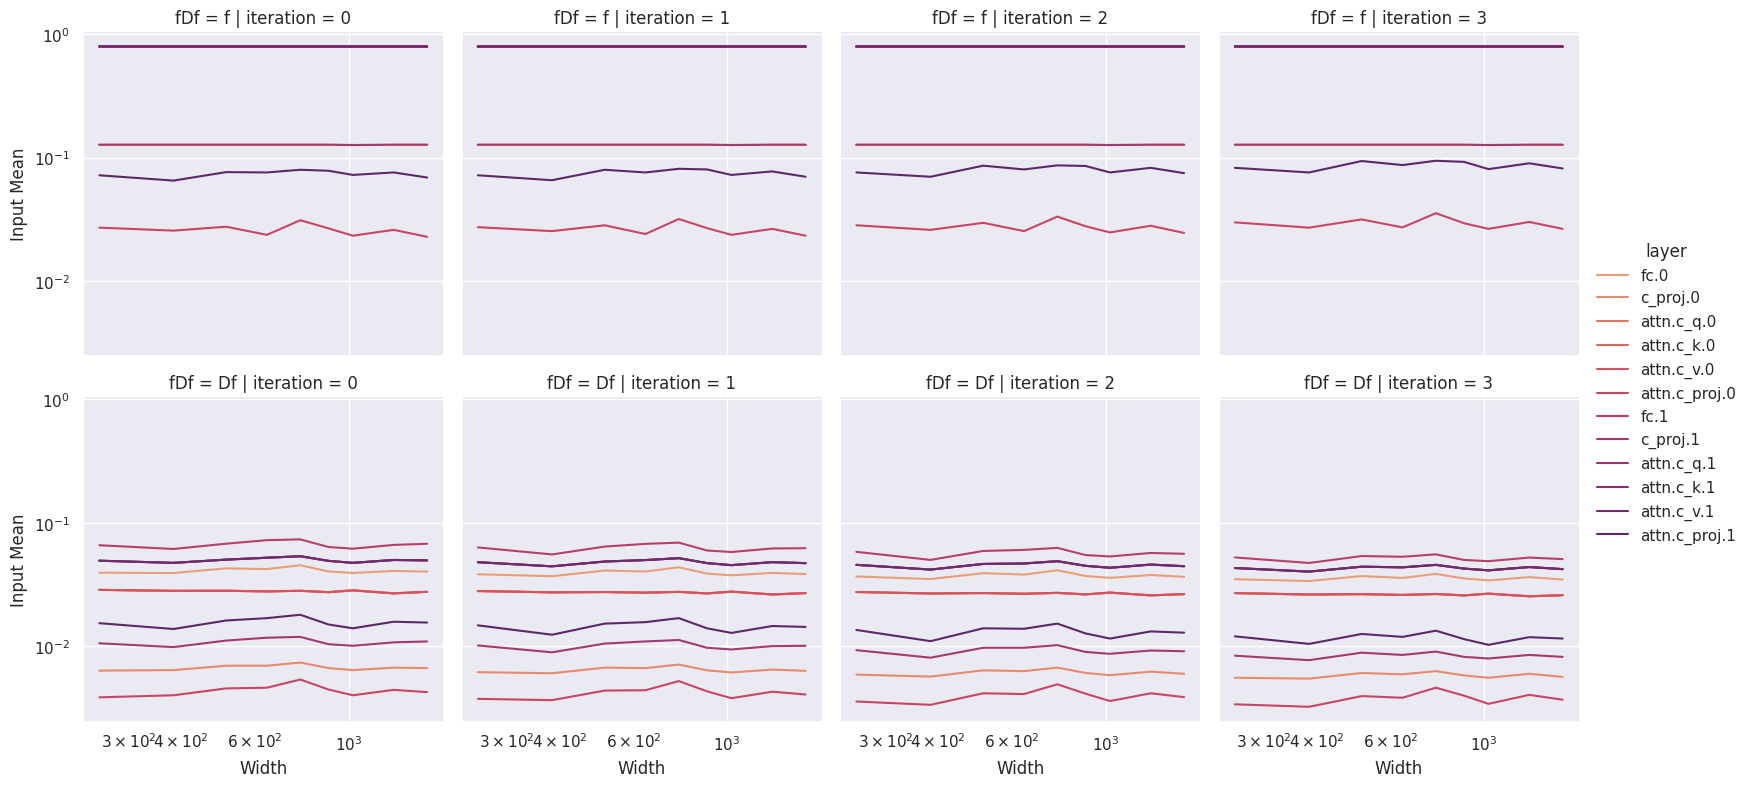

In [53]:
layer_type = "input"
data_type = "mean"

# filtered = df[df["fDf"] == "Df"]
filtered = df
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
filtered = filtered[filtered["layer"] != "output"]

ouput_rows = filtered['layer'].str.contains("lm_head")
if layer_type == "weight":
    filtered.loc[ouput_rows, 'value'] = filtered.loc[ouput_rows, 'value'] / (filtered.loc[ouput_rows, 'width'] / 256)**(1/2)

# drop the lm_head rows
filtered = filtered[filtered['layer'] != 'lm_head']

drop_cols = ["layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

p = sns.relplot(
    data=filtered,
    x="width",
    y="value",
    row="fDf",
    hue="layer",
    col="iteration",
    kind="line",
    palette="flare",
    height=4,
    )

# p.set(ylim=[0.0, 0.02])
p.set(xscale='log', yscale='log')
p.set_axis_labels(
    "Width", 
    f"{layer_type.capitalize()} {data_type.capitalize()}"
)

# # For each line in each sublot, compute a linear fit in the log-log space. Then print all the label, iteration, slope tuples
# for ax in p.axes.flatten():
#     for line in ax.get_lines():
#         xdata = line.get_xdata()
#         ydata = line.get_ydata()
#         if type(xdata) is not np.ndarray or type(ydata) is not np.ndarray:
#             continue
#         # Filter out non-positive and non-finite values
#         mask = (xdata > 0) & (ydata > 0) & np.isfinite(xdata) & np.isfinite(ydata)
#         xdata_valid = xdata[mask]
#         ydata_valid = ydata[mask]
#         if len(xdata_valid) < 2:
#             continue  # Not enough points to fit
#         # Shift so minimum is at 1
#         xdata_shifted = xdata_valid - xdata_valid.min() + 1
#         ydata_shifted = ydata_valid - ydata_valid.min() + 1
#         log_x = np.log(xdata_shifted)
#         log_y = np.log(ydata_shifted)
#         slope, intercept = np.polyfit(log_x, log_y, 1)
#         label = line.get_label()
#         if label.startswith('_child'):
#             # Try to get the legend text for this line
#             legend = ax.get_legend()
#             if legend is not None:
#                 handles, texts = legend.legendHandles, legend.texts
#                 for h, t in zip(handles, texts):
#                     if h == line:
#                         label = t.get_text()
#                         break
#         iteration = ax.get_title().split(' = ')[1]
#         print(f"Label: {label}, Iteration: {iteration}, Slope: {slope:.4e}")

In [35]:
import torch

def spectral_norm_svd(A: torch.Tensor) -> float:
    # return torch.linalg.matrix_norm(A, ord=2)
    return torch.linalg.svdvals(A.to(torch.float32)).max()

def natural_spectral_norm(A: torch.Tensor) -> float:
    # return torch.linalg.matrix_norm(A, ord='fro')
    return spectral_norm_svd(A) * math.sqrt(A.size(1) / A.size(0))

[64, 288, 512, 736, 960, 1184, 1408, 1632, 1856, 2080, 2304, 2528]


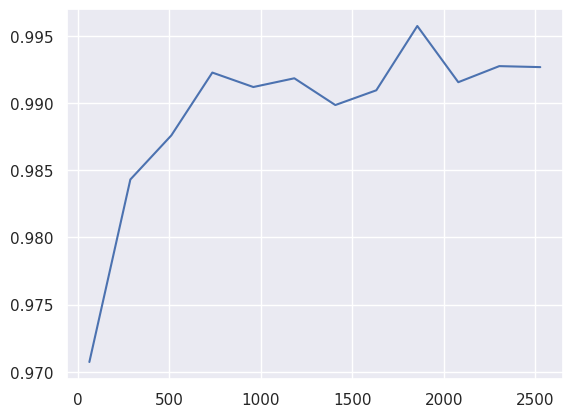

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# sizes = [32, 64, 128, 256, 512, 1024, 2048]
sizes = [32 * i for i in range(2, 80, 7)]
print(sizes)
heads = [1, 2, 2, 4, 8, 2, 6]
data = []
samples = 15

for size in sizes:
    avg = 0
    for sample in range(samples):
        H = 64
        m = size // 64
        r = size // H

        x = torch.randn(H, size) * ( 1 / (r**(1/2)*( size**(1/2) + H**(1/2) )) )
        x = torch.cat([x] * r, dim=0)


        norm = spectral_norm_svd(x)
        avg += norm / samples

    data.append(avg)


plt.plot(sizes, data)

In [402]:
def app_fun(max_depth, x):
    try:
        # print(x)
        new = f"{'.'.join(x.split('.')[:-1])}.{max_depth - int(x.split('.')[-1])}"
        # print(new)
        return new
    except Exception as e:
        return x

def invert_layers(df):
    # get depth and replace each layer id by depth - id

    # apply to each depth separetly 
    for depth in df['depth'].unique():
        max_depth = depth
        df_depth = df[df['depth'] == depth]        
        # print(df_depth)
        # print(max_depth)
        # apply the function to the layer column
        
        # df_depth['layer'] = df_depth['layer'].apply(lambda x: app_fun(max_depth, x))
        df.loc[df['depth'] == depth, 'layer'] = df_depth['layer'].apply(lambda x: app_fun(max_depth, x))
    # fun = lambda x: app_fun(max_depth, x)
    # df['layer'] = df['layer'].apply(fun)
    return df


In [403]:
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/2025-08-01_22-15-51"

dfs = []
for root, dirs, files in os.walk(fs):
    for f in files:
        if ".csv" in f:
            dfs.append(pd.read_csv(os.path.join(root, f)))

df = pd.concat(dfs, ignore_index=True)

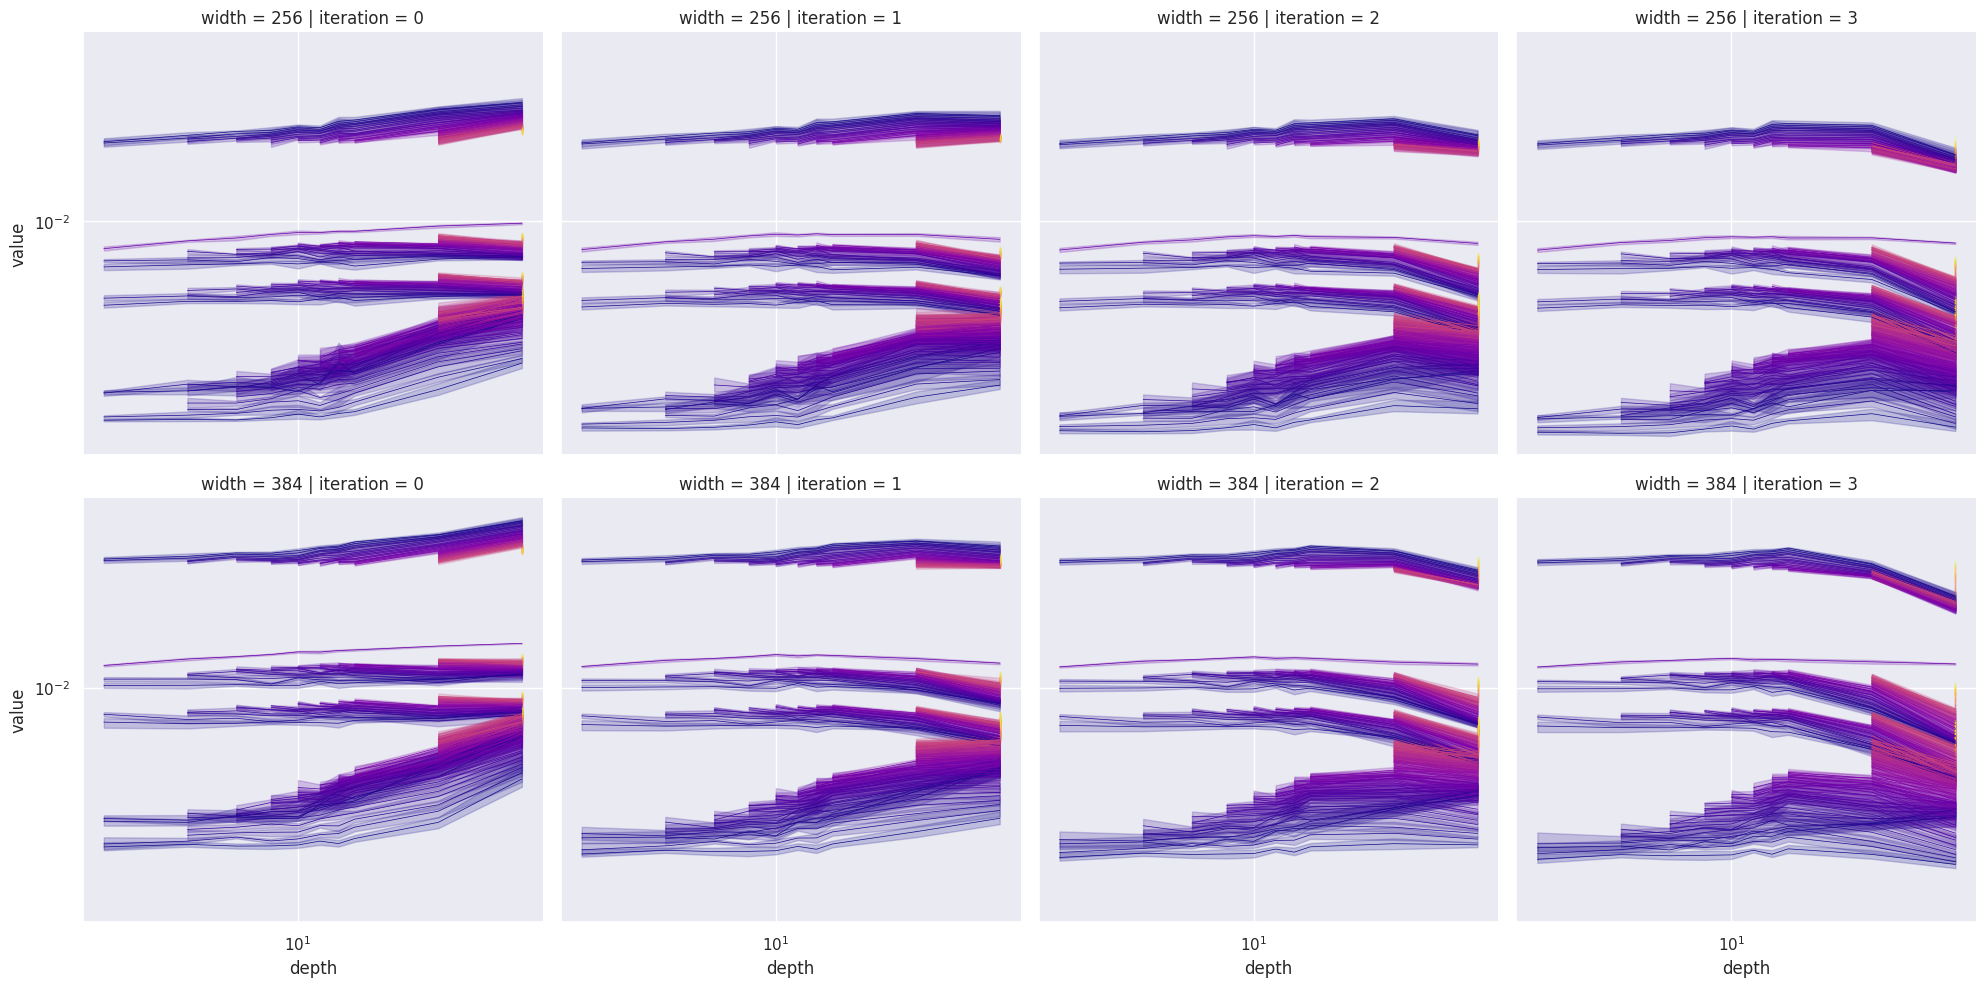

In [404]:
layer_type = "weight"
data_type = "norm"

filtered = df[df["fDf"] == "Df"]
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
filtered = filtered[filtered["layer"] != "output"]

# lm_head weights are intentionally too big and have a multiplier applied during forward passes
# lm_head_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[lm_head_rows, 'value'] = filtered.loc[lm_head_rows, 'value'] / filtered.loc[lm_head_rows, 'width']

# # if layer_type == "input":
# filtered = filtered[filtered['layer'].str.contains("attn.c_proj")]
# # else:
# filtered = filtered[filtered['layer'].str.contains("attn.c_q")]

# attn_c_q_rows = filtered['layer'].str.contains("attn.c_q")
# filtered.loc[attn_c_q_rows, 'value'] = filtered.loc[attn_c_q_rows, 'value'] #* (filtered.loc[attn_c_q_rows, 'width'])

# filtered.loc[:, 'value'] = filtered['value'] * (filtered['width'])**(1/2)

# c_rows = filtered['layer'].str.contains("attn.c_kv")
# filtered.loc[c_rows, 'value'] /= (filtered.loc[c_rows, 'width'] / 256)**(1/3)

# filtered[filtered['layer'].str.contains("c_proj")] *= (filtered[filtered['layer'].str.contains("c_proj")]['width'] / 256)**(1/2)

drop_cols = ["fDf", "layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

p = sns.relplot(
    data=filtered,
    row="width",
    x="depth",
    y="value",
    hue="layer",
    col="iteration",
    kind="line",
    palette="plasma",
    legend=False,
    linewidth=0.5
)

# p.set(ylim=[0.0, 0.02])
p.set(yscale='log', xscale='log')
# p.set_axis_labels(
#     "Width", 
#     f"{layer_type.capitalize()} {data_type.capitalize()}"
# )

In [405]:
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/2025-08-01_22-16-02"

dfs = []
for root, dirs, files in os.walk(fs):
    for f in files:
        if ".csv" in f:
            dfs.append(pd.read_csv(os.path.join(root, f)))

df = pd.concat(dfs, ignore_index=True)

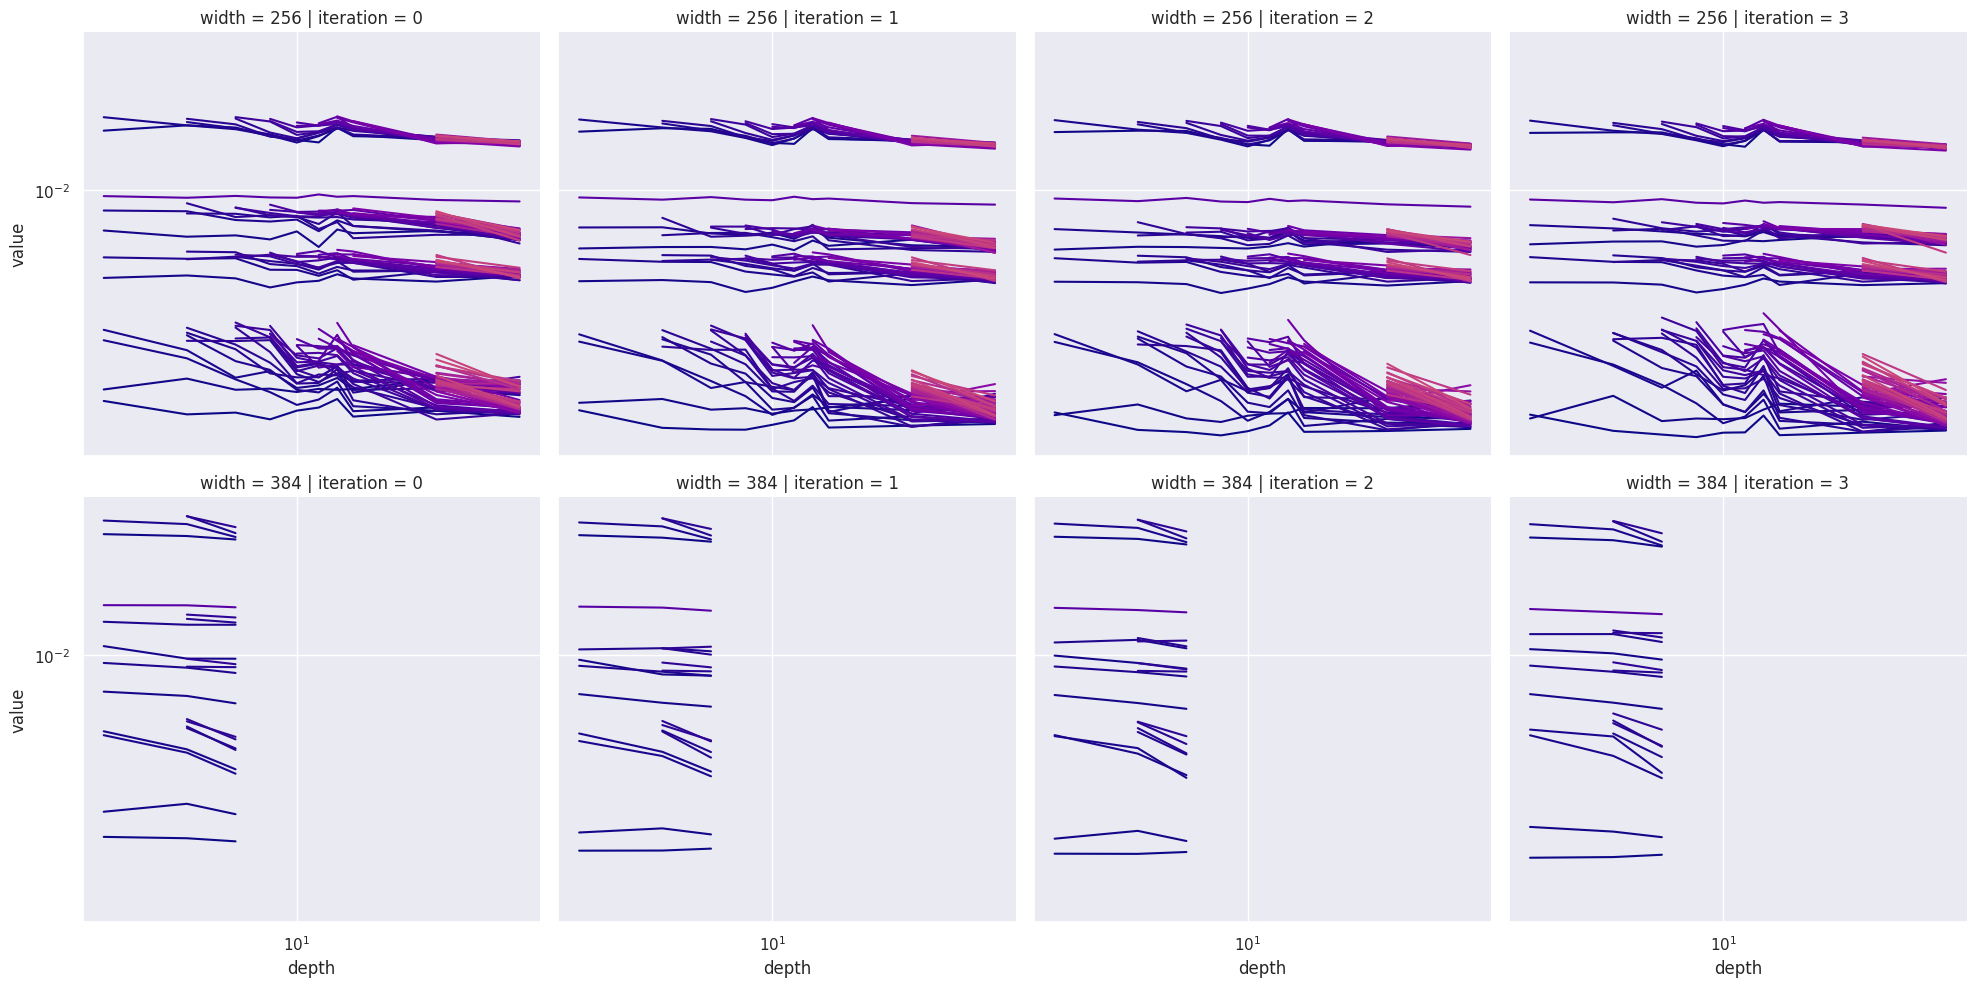

In [406]:
layer_type = "weight"
data_type = "norm"

filtered = df[df["fDf"] == "Df"]
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
filtered = filtered[filtered["layer"] != "output"]

# lm_head weights are intentionally too big and have a multiplier applied during forward passes
# lm_head_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[lm_head_rows, 'value'] = filtered.loc[lm_head_rows, 'value'] / filtered.loc[lm_head_rows, 'width']

# # if layer_type == "input":
# filtered = filtered[filtered['layer'].str.contains("attn.c_proj")]
# # else:
# filtered = filtered[filtered['layer'].str.contains("attn.c_q")]

# attn_c_q_rows = filtered['layer'].str.contains("attn.c_q")
# filtered.loc[attn_c_q_rows, 'value'] = filtered.loc[attn_c_q_rows, 'value'] #* (filtered.loc[attn_c_q_rows, 'width'])

# filtered.loc[:, 'value'] = filtered['value'] * (filtered['width'])**(1/2)

# c_rows = filtered['layer'].str.contains("attn.c_kv")
# filtered.loc[c_rows, 'value'] /= (filtered.loc[c_rows, 'width'] / 256)**(1/3)

# filtered[filtered['layer'].str.contains("c_proj")] *= (filtered[filtered['layer'].str.contains("c_proj")]['width'] / 256)**(1/2)

drop_cols = ["fDf", "layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

p = sns.relplot(
    data=filtered,
    row="width",
    x="depth",
    y="value",
    hue="layer",
    col="iteration",
    kind="line",
    palette="plasma",
    legend=False
)

# p.set(ylim=[0.0, 0.02])
p.set(yscale='log', xscale='log')
# p.set_axis_labels(
#     "Width", 
#     f"{layer_type.capitalize()} {data_type.capitalize()}"
# )

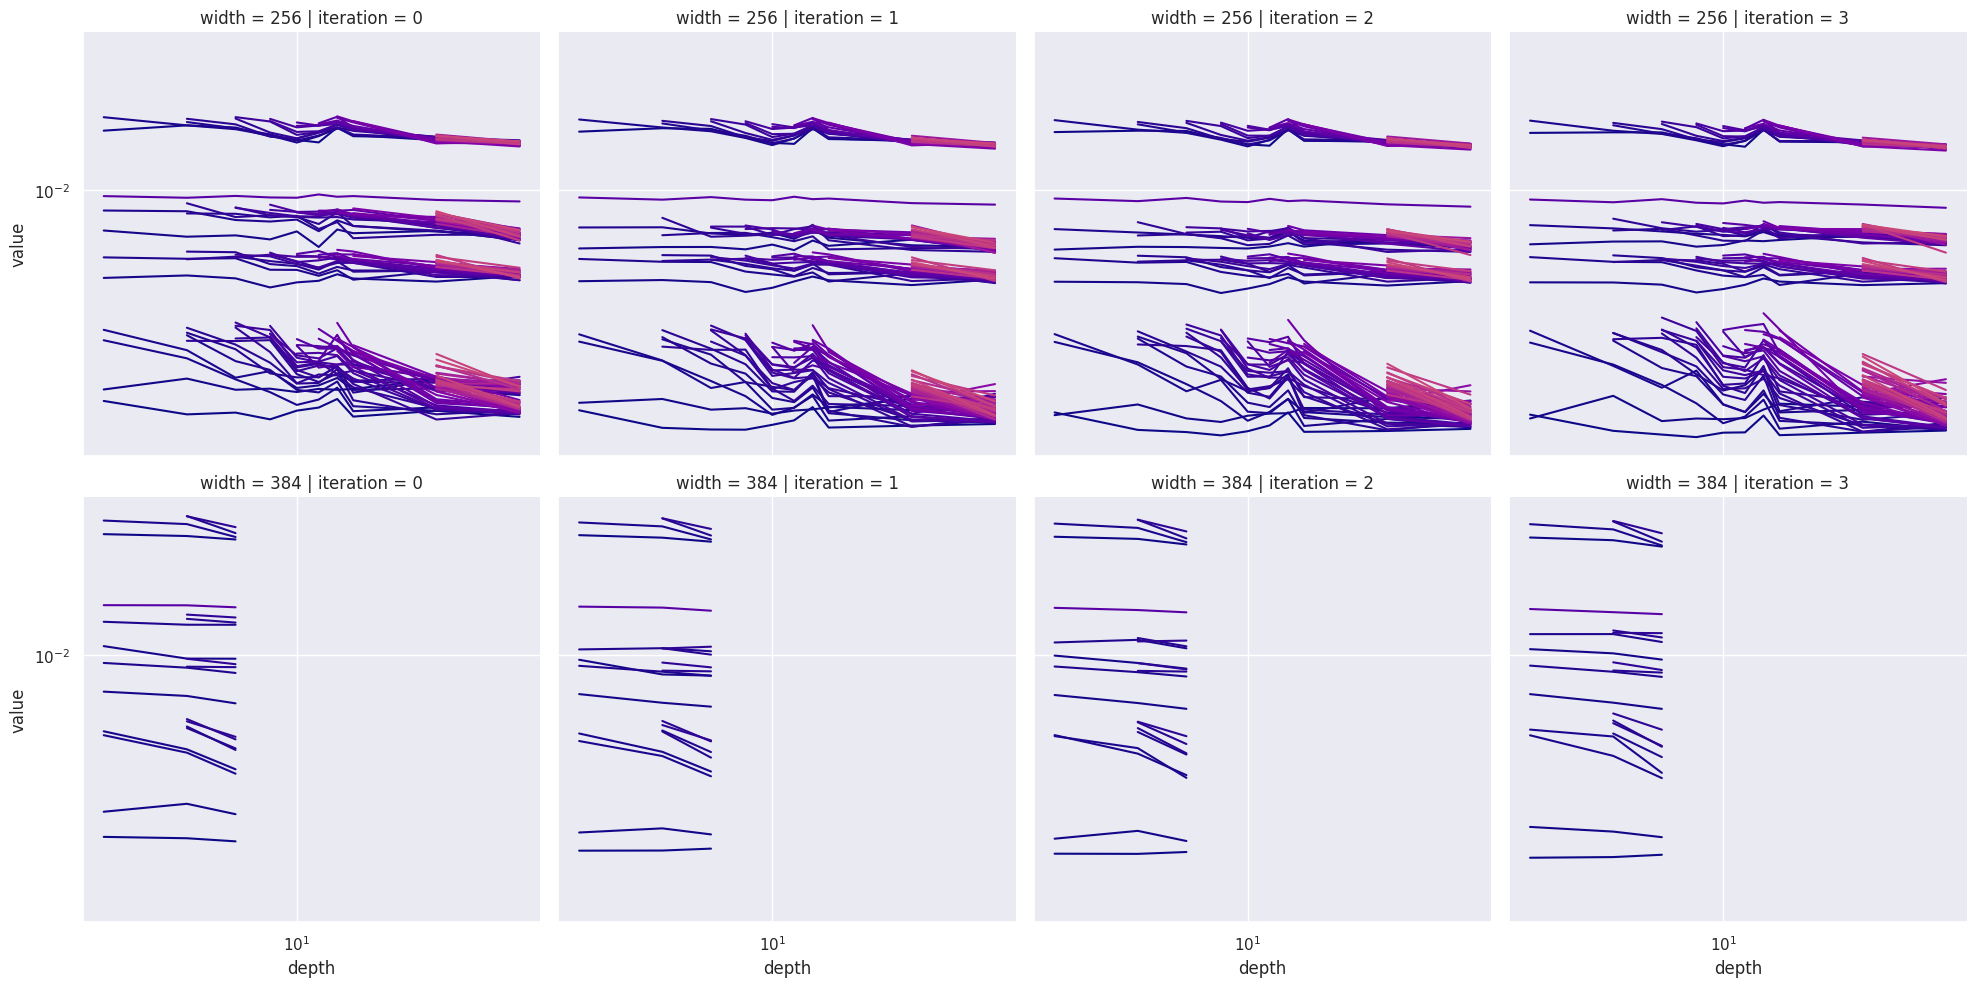

In [407]:
layer_type = "weight"
data_type = "norm"

filtered = df[df["fDf"] == "Df"]
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
filtered = filtered[filtered["layer"] != "output"]

# lm_head weights are intentionally too big and have a multiplier applied during forward passes
# lm_head_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[lm_head_rows, 'value'] = filtered.loc[lm_head_rows, 'value'] / filtered.loc[lm_head_rows, 'width']

# # if layer_type == "input":
# filtered = filtered[filtered['layer'].str.contains("attn.c_proj")]
# # else:
# filtered = filtered[filtered['layer'].str.contains("attn.c_q")]

# attn_c_q_rows = filtered['layer'].str.contains("attn.c_q")
# filtered.loc[attn_c_q_rows, 'value'] = filtered.loc[attn_c_q_rows, 'value'] #* (filtered.loc[attn_c_q_rows, 'width'])

# filtered.loc[:, 'value'] = filtered['value'] * (filtered['width'])**(1/2)

# c_rows = filtered['layer'].str.contains("attn.c_kv")
# filtered.loc[c_rows, 'value'] /= (filtered.loc[c_rows, 'width'] / 256)**(1/3)

# filtered[filtered['layer'].str.contains("c_proj")] *= (filtered[filtered['layer'].str.contains("c_proj")]['width'] / 256)**(1/2)

drop_cols = ["fDf", "layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

p = sns.relplot(
    data=filtered,
    row="width",
    x="depth",
    y="value",
    hue="layer",
    col="iteration",
    kind="line",
    palette="plasma",
    legend=False
)

# p.set(ylim=[0.0, 0.02])
p.set(yscale='log', xscale='log')
# p.set_axis_labels(
#     "Width", 
#     f"{layer_type.capitalize()} {data_type.capitalize()}"
# )

In [408]:
layer_type = "weight"
data_type = "norm"

filtered = df[df["fDf"] == "f"]
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
filtered = filtered[filtered["layer"] != "output"]

# lm_head weights are intentionally too big and have a multiplier applied during forward passes
# lm_head_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[lm_head_rows, 'value'] = filtered.loc[lm_head_rows, 'value'] / filtered.loc[lm_head_rows, 'width']

# # if layer_type == "input":
# filtered = filtered[filtered['layer'].str.contains("attn.c_proj")]
# # else:
# filtered = filtered[filtered['layer'].str.contains("attn.c_kv")]

# attn_c_q_rows = filtered['layer'].str.contains("attn.c_q")
# filtered.loc[attn_c_q_rows, 'value'] = filtered.loc[attn_c_q_rows, 'value'] #* (filtered.loc[attn_c_q_rows, 'width'])

# filtered.loc[:, 'value'] = filtered['value'] * (filtered['width'])**(1/2)

# c_rows = filtered['layer'].str.contains("attn.c_kv")
# filtered.loc[c_rows, 'value'] /= (filtered.loc[c_rows, 'width'] / 256)**(1/3)

# filtered[filtered['layer'].str.contains("c_proj")] *= (filtered[filtered['layer'].str.contains("c_proj")]['width'] / 256)**(1/2)

drop_cols = ["fDf", "layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

p = sns.relplot(
    data=filtered,
    x="depth",
    y="value",
    hue="layer",
    style=""
    col="iteration",
    kind="line",
    palette="tab10"
)

p.set(xscale='log', yscale='log')
p.set_axis_labels(
    "Width", 
    f"{layer_type.capitalize()} {data_type.capitalize()}"
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1009347432.py, line 37)

In [ ]:
text = """
435075      main coord_ch kyle.chi  R      12:42      1 fs-mbz-gpu-403
435073      main coord_ch kyle.chi  R      21:20      1 fs-mbz-gpu-876
435045      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-868
435048      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-807
435049      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-830
435050      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-833
435051      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-878
435052      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-666
435053      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-647
435054      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-672
435055      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-679
435056      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-685
435057      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-627
435058      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-728
435059      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-865
435060      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-886
435061      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-832
435062      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-150
435063      main sweep_et kyle.chi  R    1:05:11      1 fs-mbz-gpu-170
"""

jobs = [line.split(" ")[0] for line in text.split("\n")]
print("scancel", end=' ')
for job in jobs:
    print(job, end=' ')
print()

scancel  435075 435073 435045 435048 435049 435050 435051 435052 435053 435054 435055 435056 435057 435058 435059 435060 435061 435062 435063  


In [ ]:
import numpy as np

y_2 = np.log(1.8*10**(-4))
y_1 = np.log(1.4*10**(-4))

x_2 = np.log(10**3)
x_1 = np.log(3 * 10**2)

slope = (y_2 - y_1) / (x_2 - x_1)
print(slope)

0.20873762877194646


In [ ]:
1/768

0.0013020833333333333

In [ ]:
import math
import torch 

def spectral_norm_svd(A: torch.Tensor) -> float:
    # return torch.linalg.matrix_norm(A, ord=2)
    return torch.linalg.svdvals(A.to(torch.float32)).max()

def natural_spectral_norm(A: torch.Tensor) -> float:
    # return torch.linalg.matrix_norm(A, ord='fro')
    return spectral_norm_svd(A) * math.sqrt(A.size(1) / A.size(0))

In [ ]:
m = [1, 2, 4, 8]
n0 = 256
hs = 64
kv_heads = 4

In [ ]:
for _m in m:
    n = n0 * _m
    n_heads = n // hs
    r = n_heads // kv_heads
    H = kv_heads * hs

    A = torch.randn(n, H) * (1 / (r**(1/2) * (_m**(1/2) + H**(1/2)/n0**(1/2))) )
    A = torch.cat([A] * r, dim=1)

    print(natural_spectral_norm(A).item())

16.056180953979492
15.799351692199707
16.040983200073242


15.863144874572754
